In [27]:
# Compute the camera calibration matrix and distortion coefficients
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Object and Image points for camera calibration
nx = 9
ny = 6
objpoints = []
imgpoints = []

objp = np.zeros((nx * ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

imgs = glob.glob('camera_cal/calibration*.jpg')
for fn in imgs:
    # Read each chessboard image
    img = cv2.imread(fn)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
# Plot images utilities
def plot_images(imgs, titles, points=None):
    rows = len(imgs)
    cols = len(imgs[0])
    f, axs = plt.subplots(rows, cols, figsize=(24, 9))
    f.tight_layout()
    
    if rows == 1:
        for i in range(cols):
            axs[i].imshow(imgs[0][i], cmap='gray')
            axs[i].set_title(titles[0][i], fontsize=20)
            if points:
                axs[i].plot(points[0][i][:,0], points[0][i][:,1], 'r')
    else:
        for i in range(rows):
            for j in range(len(imgs[i])):
                axs[i][j].imshow(imgs[i][j], cmap='gray')
                axs[i][j].set_title(titles[i][j], fontsize=20)
                if points:
                    axs[i][j].plot(points[i][j][:,0], points[i][j][:,1], 'r')
    plt.subplots_adjust(left=0., right=1, top=1.1, bottom=0.)
    
def undist(img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

# Gradient operations
def sobel_xy(img, orient='x', kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel))
    if orient == 'y':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel))
    # Rescale back to 8 bit integer
    sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary = np.zeros_like(sobel)
    binary[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    return binary

def sobel_mag(img, kernel=9, thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # Calculate the gradient magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    mag = np.uint8(255*mag/np.max(mag))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary = np.zeros_like(mag)
    binary[(mag >= thresh[0]) & (mag <= thresh[1])] = 1
    return binary

def sobel_dir(img, kernel=15, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    direct = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary = np.zeros_like(direct, dtype=np.uint8)
    binary[(direct >= thresh[0]) & (direct <= thresh[1])] = 1
    return binary

# So S-channel is a better start for combining with gradients
# R: (200, 255), S: (90, 255), H: (15, 100), Gray: (180, 255)
# Get binary applied thresh in s_channel
def s_channel(img, thresh = (90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def h_channel(img, thresh = (15, 100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    return binary

def r_channel(img, thresh = (200, 255)):
    R = img[:,:,0]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

def warpMtx():
    src = np.float32([ [272, 719], [605, 490], [735+20, 490], [1031, 719] ])
    dst = np.float32([ [200, 719], [200, 200], [900, 200], [900, 719] ])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv, src, dst

In [51]:
"""Find lane from exist lane"""
def __find_lane_1(warped):
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    A, B, C = left_fit
    left_lane_inds = ((nonzerox > (A * (nonzeroy**2) + B * nonzeroy + C - margin)) \
                      & (nonzerox < (A * (nonzeroy**2) + B * nonzeroy + C + margin)))
    A, B, C = right_fit
    right_lane_inds = ((nonzerox > (A * (nonzeroy**2) + B * nonzeroy + C - margin)) \
                        & (nonzerox < (A * (nonzeroy**2) + B * nonzeroy + C + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

def __find_lane_0(warped):
    hist = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    #out_img = np.dstack((warped, warped, warped)) * 255
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    if len(left_lane_inds) < 2 or len(right_lane_inds) < 2:
        return False, None, None, None, None, None

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    #print('===>left min:', np.amin(lefty), 'right min:', np.amin(righty))
    y_min = max(np.amin(lefty), np.amin(righty))
    #print('====>y_min:', y_min)
    # Generate x and y values for plotting
    ploty = np.linspace(y_min, warped.shape[0]-1, warped.shape[0]-y_min)
    #ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return True, left_fitx, right_fitx, ploty, left_fit, right_fit

def find_lane(warped):
    if detected:
        left_fit, right_fit = self.__find_lane_1(warped)
    else:
        left_fit, right_fit = self.__find_lane_0(warped)
        detected = True
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0] )
    A, B, C = self.left_fit
    left_fitx = A * ploty**2 + B * ploty + C
    A, B, C = self.right_fit
    right_fitx = A * ploty**2 + B * ploty + C

    return left_fitx, right_fitx, ploty

def show_lane_line(left_fitx, right_fitx, ploty):
    out_img = np.dstack((warped, warped, warped)) * 255
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    ## Draw Lane
    lane_img = np.zeros_like(out_img)
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((left_line, right_line))
    cv2.fillPoly(lane_img, np.int_([lane_pts]), (0, 255, 0))

    return cv2.addWeighted(out_img, 1, lane_img, 0.3, 0)

def combine (img):
    R = r_channel(img, thresh=(170, 255))

    # R-channel +　sobel-x
    #com = np.zeros_like(rchn)
    #com[(R == 1) | (sobelx == 1)] = 1

    return R

def draw_lane(img):
    undist_img = undist(img)

    com_img = combine(undist_img)

    img_size = (img.shape[1], img.shape[0])
    M, Minv, src, dst = warpMtx()
    warped = cv2.warpPerspective(com_img, M, img_size, flags=cv2.INTER_LINEAR)

    find, left_fitx, right_fitx, ploty, left_fit, right_fit = find_lane(warped)

    if not find:
        return None
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    return result

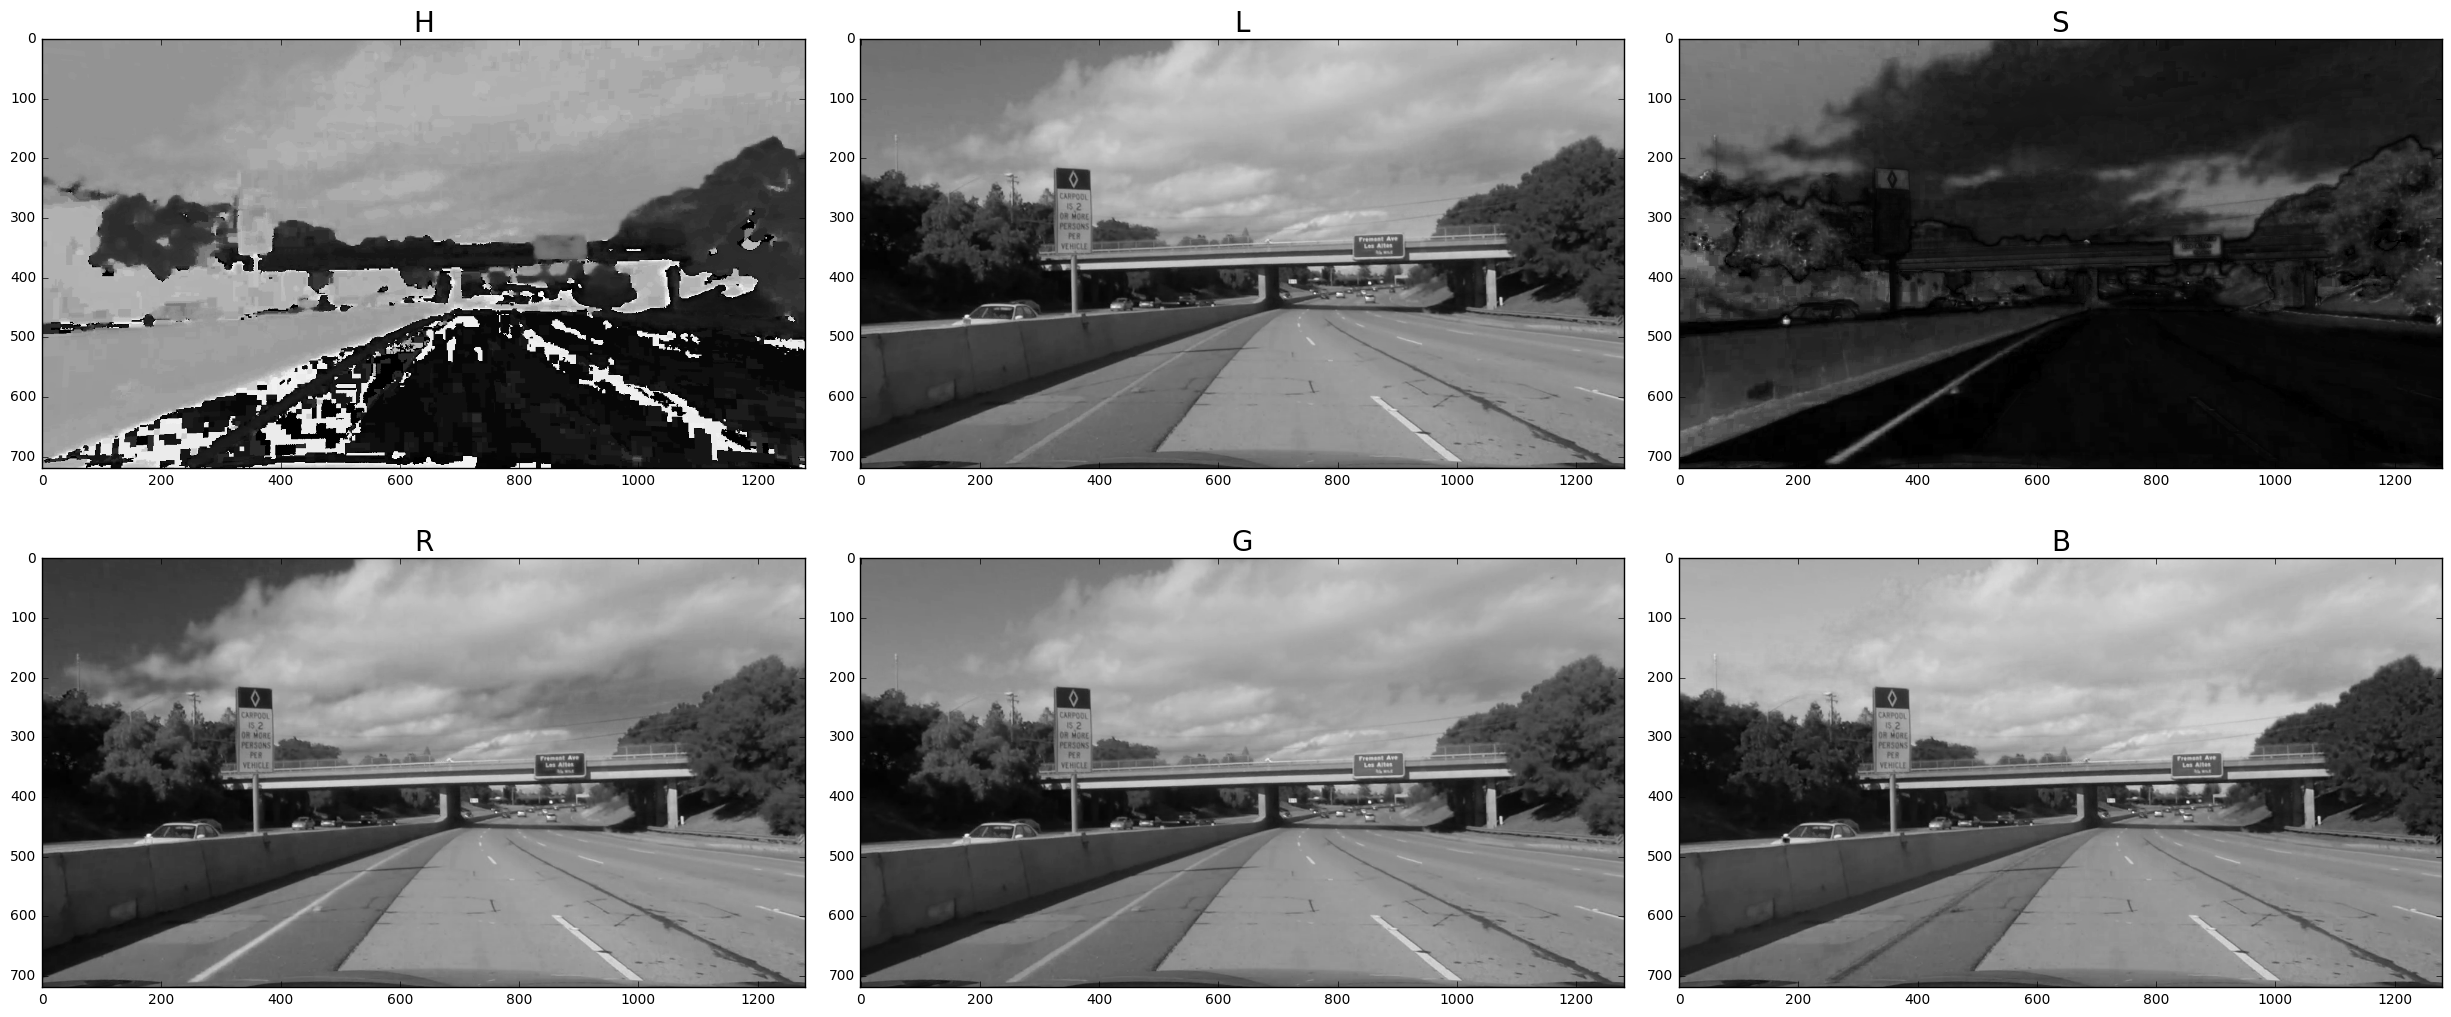

In [3]:
from moviepy.editor import VideoFileClip

video_output = 'challenge_output.mp4'
clip = VideoFileClip('challenge_video.mp4')

img = clip.get_frame(2)
undist_img = undist(img)

R, G, B = undist_img[:,:,0], undist_img[:,:,1], undist_img[:,:,2]
hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
H, L, S = hls[:,:,0], hls[:,:,1], hls[:,:,2]

plot_images([ [H, L, S], [R, G, B] ], [ ['H', 'L', 'S'], ['R', 'G', 'B'] ])

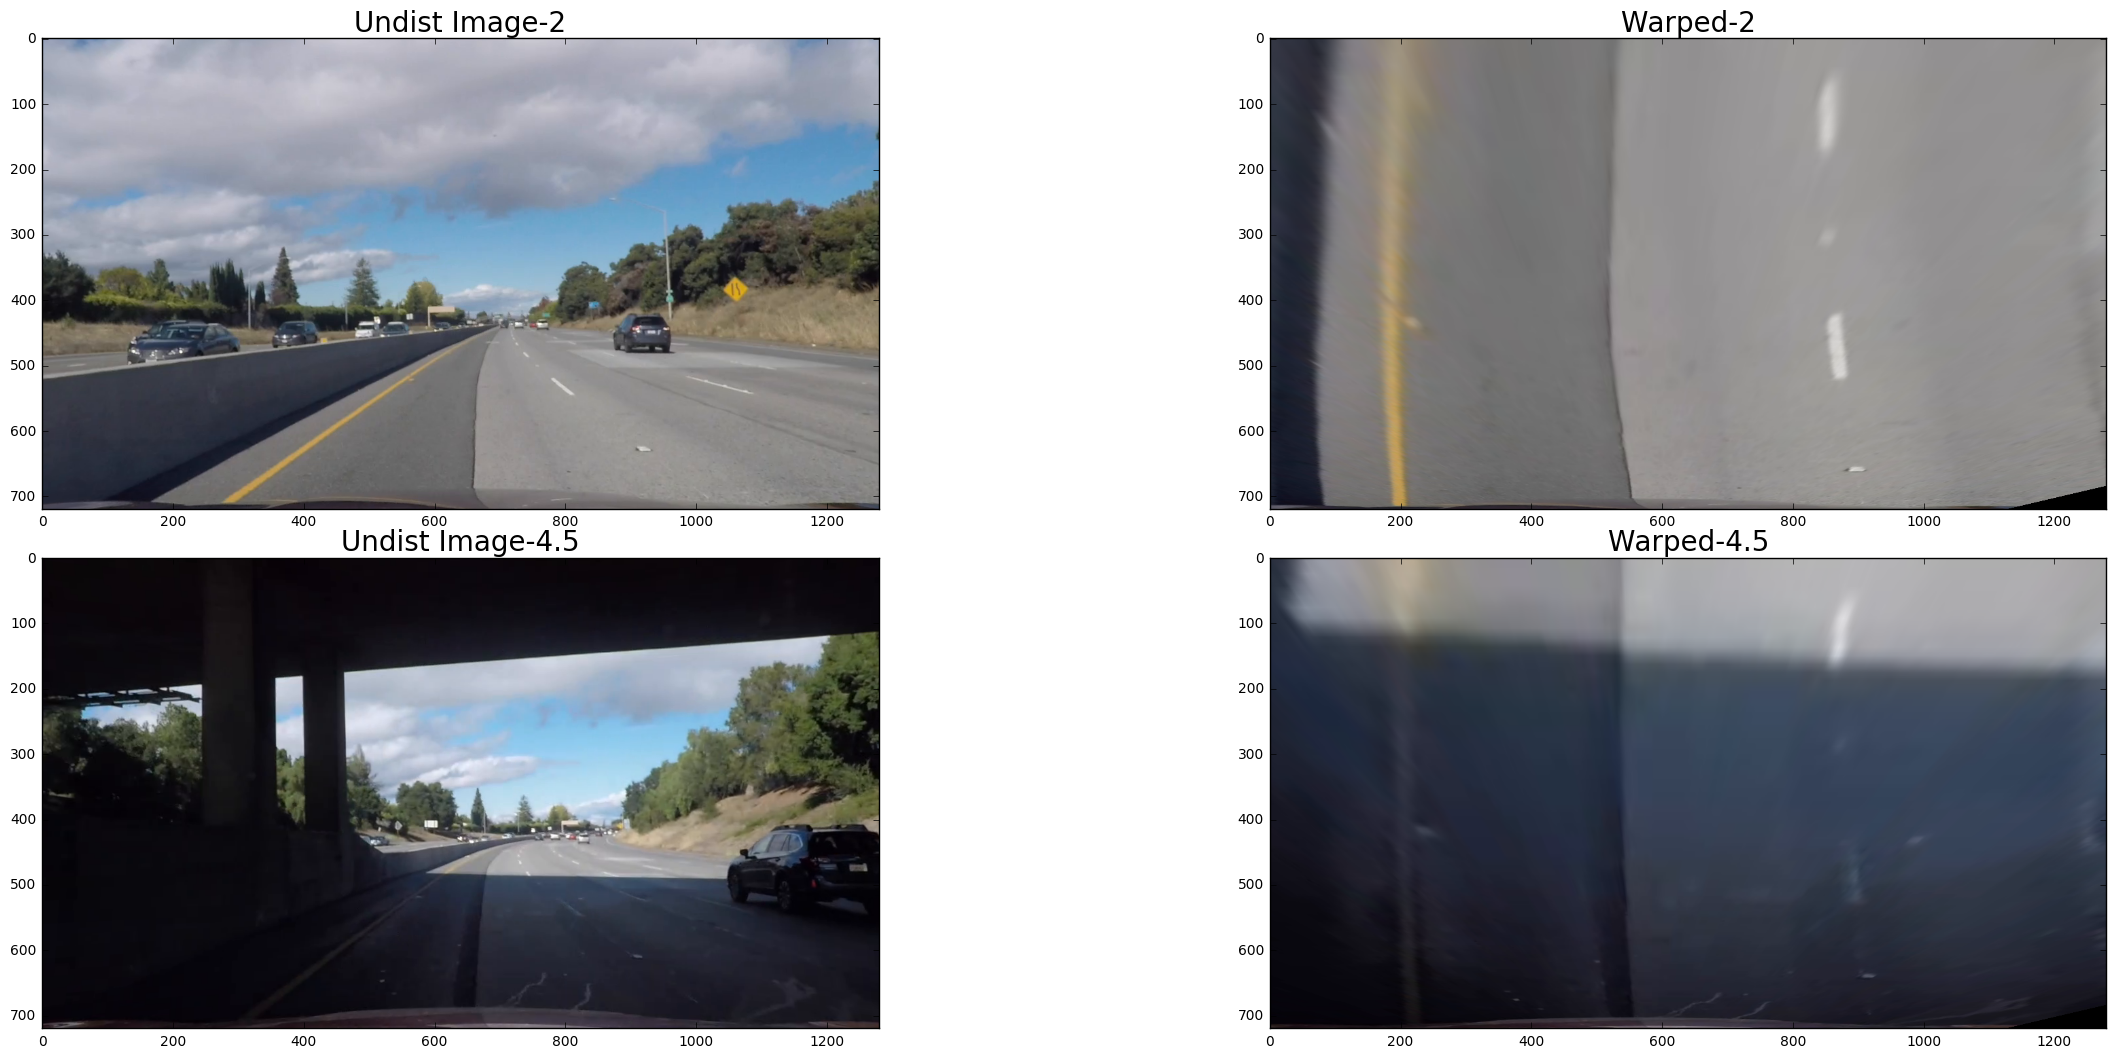

In [21]:
clip = VideoFileClip('challenge_video.mp4')
img1 = clip.get_frame(10)
img2 = clip.get_frame(4.5)

undist_img1 = undist(img1)
undist_img2 = undist(img2)

M, Minv, src, dst = warpMtx()

img_size = (undist_img1.shape[1], undist_img1.shape[0])
warped1 = cv2.warpPerspective(undist_img1, M, img_size, flags=cv2.INTER_LINEAR)

img_size = (undist_img2.shape[1], undist_img2.shape[0])
warped2 = cv2.warpPerspective(undist_img2, M, img_size, flags=cv2.INTER_LINEAR)

plot_images([[undist_img1, warped1], [undist_img2, warped2]], \
            [['Undist Image-2', 'Warped-2'], ['Undist Image-4.5', 'Warped-4.5']])

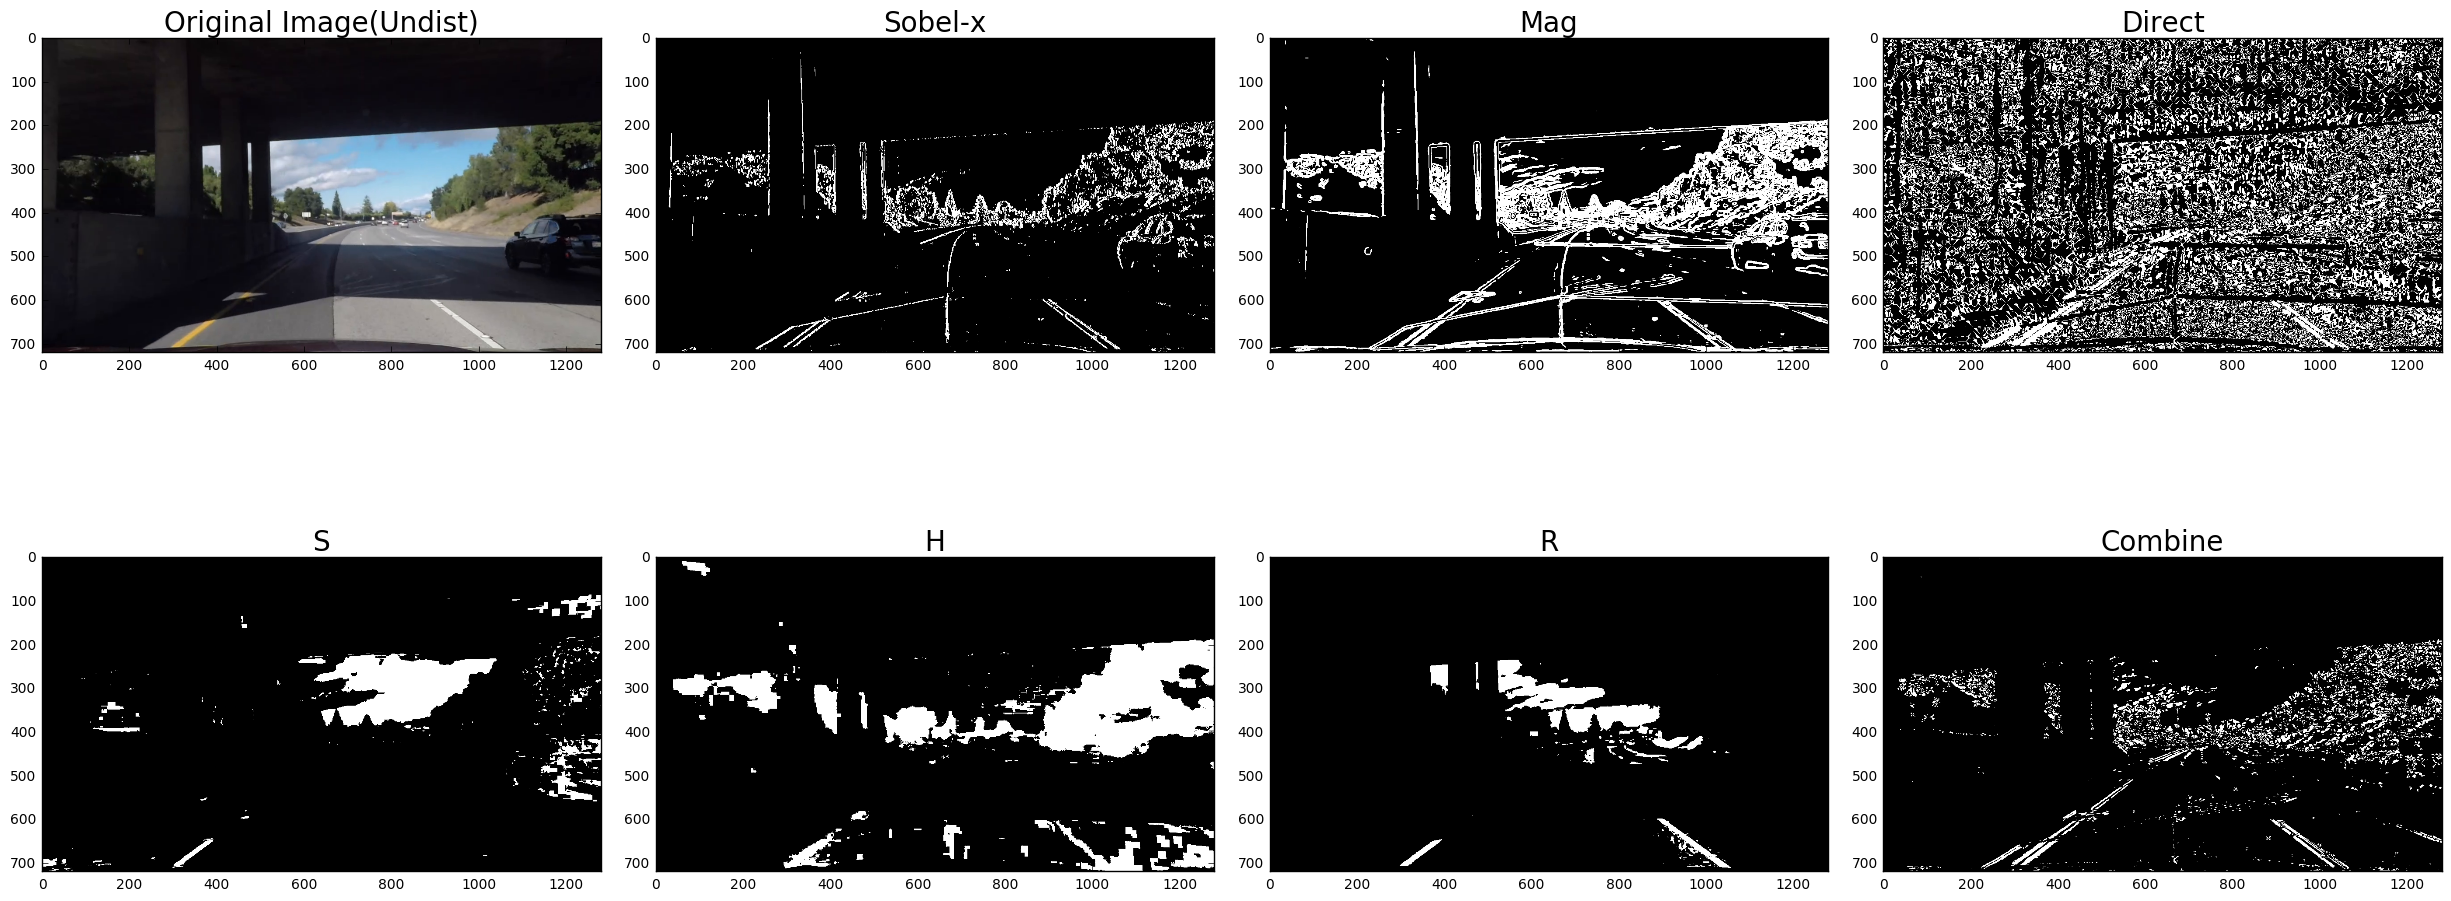

In [71]:
img = clip.get_frame(4.3)
undist_img = undist(img)

R = r_channel(undist_img, thresh=(170, 255))
sobelx = sobel_xy(undist_img, thresh=(10, 100))
mag = sobel_mag(undist_img, thresh=(10, 100))
dirt = sobel_dir(undist_img, thresh=(0.7, 1.3))
S = s_channel(undist_img, thresh=(100, 255))
H = h_channel(undist_img, thresh=(15, 100))
R = r_channel(undist_img, thresh=(170, 255))

com_img = np.zeros_like(R)
com_img[(mag == 1) & (dirt == 1)] = 1

plot_images([ [undist_img, sobelx, mag, dirt], [S, H, R, com_img] ], \
            [ ['Original Image(Undist)', 'Sobel-x', 'Mag', 'Direct'], [ 'S', 'H', 'R', 'Combine'] ])

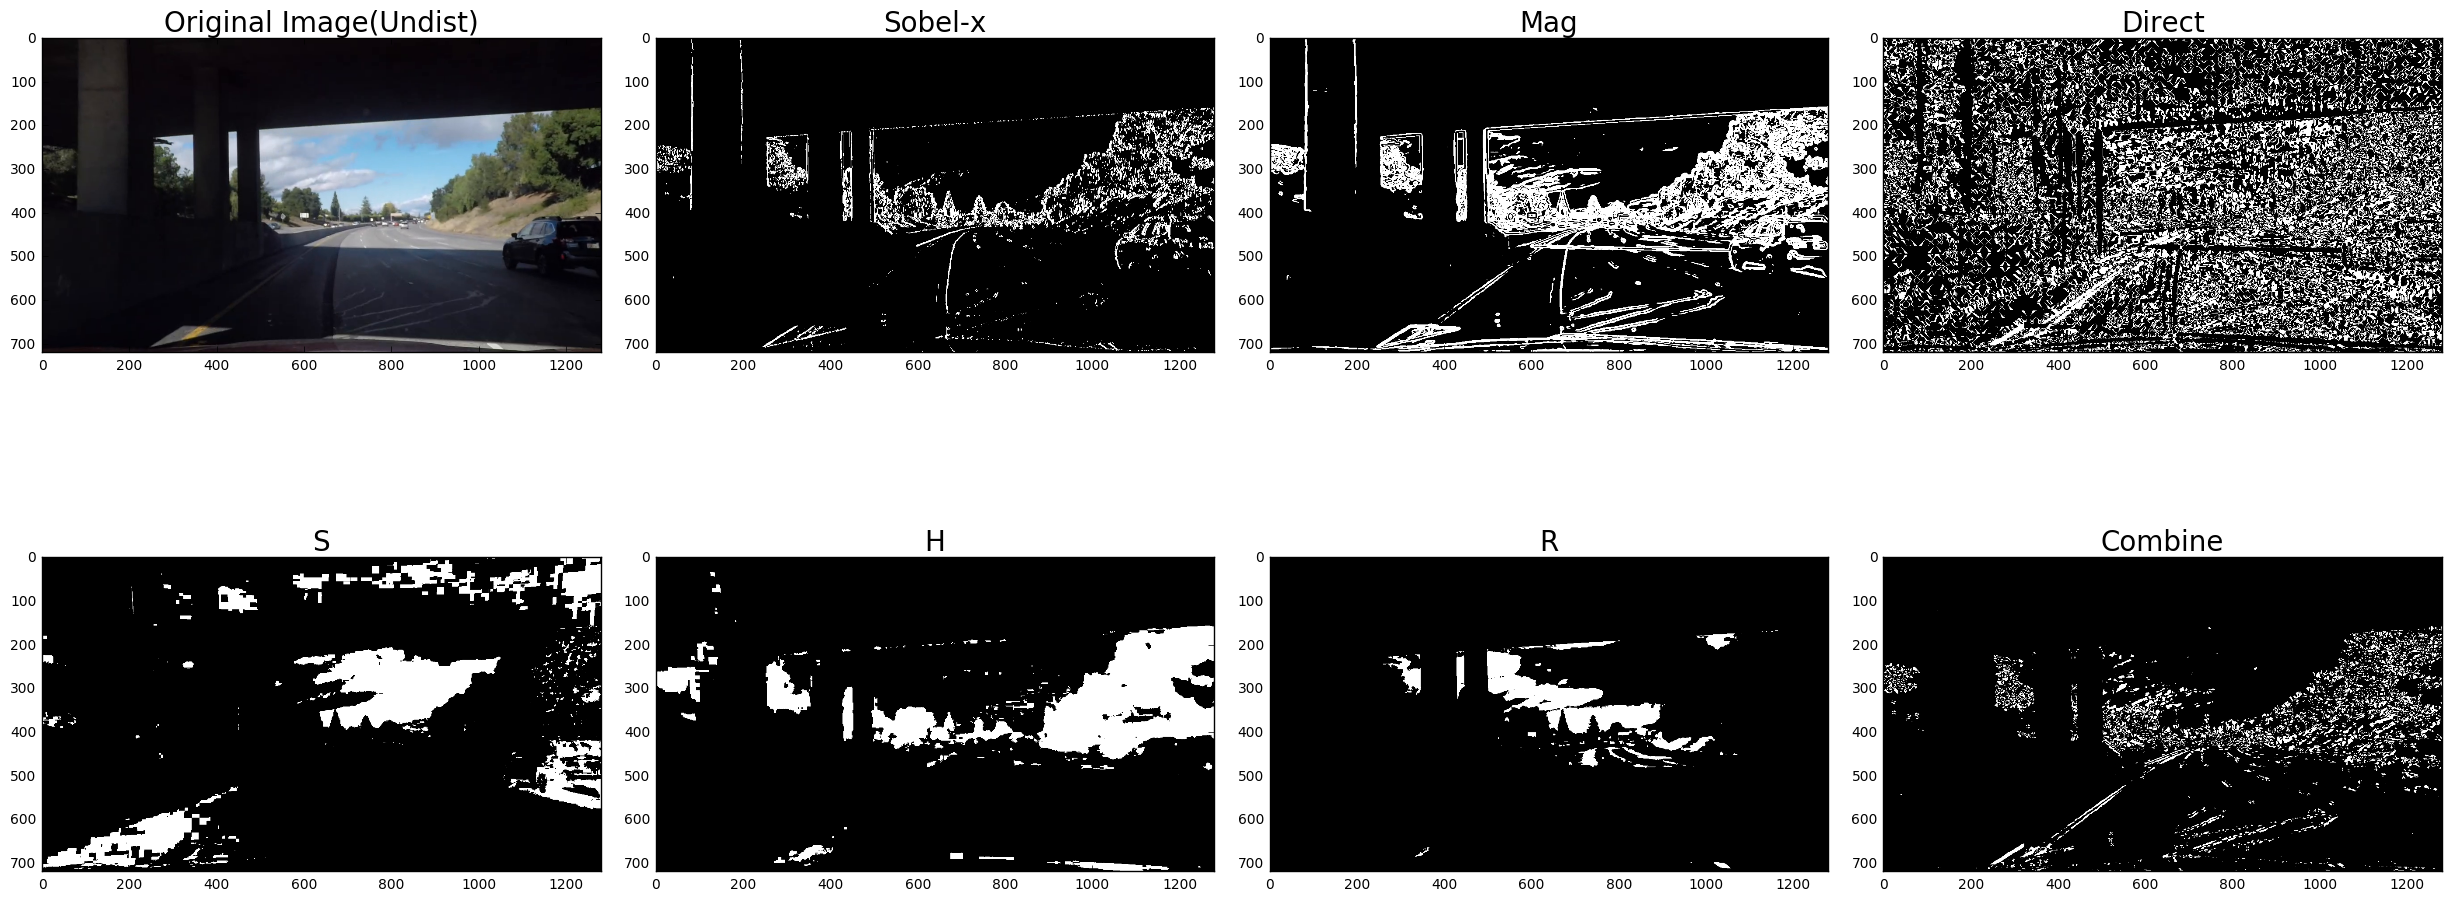

In [72]:
img = clip.get_frame(4.4)
undist_img = undist(img)

R = r_channel(undist_img, thresh=(170, 255))
sobelx = sobel_xy(undist_img, thresh=(10, 100))
mag = sobel_mag(undist_img, thresh=(10, 100))
dirt = sobel_dir(undist_img, thresh=(0.7, 1.3))
S = s_channel(undist_img, thresh=(100, 255))
H = h_channel(undist_img, thresh=(15, 100))
R = r_channel(undist_img, thresh=(170, 255))

com_img = np.zeros_like(R)
com_img[(mag == 1) & (dirt == 1)] = 1

plot_images([ [undist_img, sobelx, mag, dirt], [S, H, R, com_img] ], \
            [ ['Original Image(Undist)', 'Sobel-x', 'Mag', 'Direct'], [ 'S', 'H', 'R', 'Combine'] ])

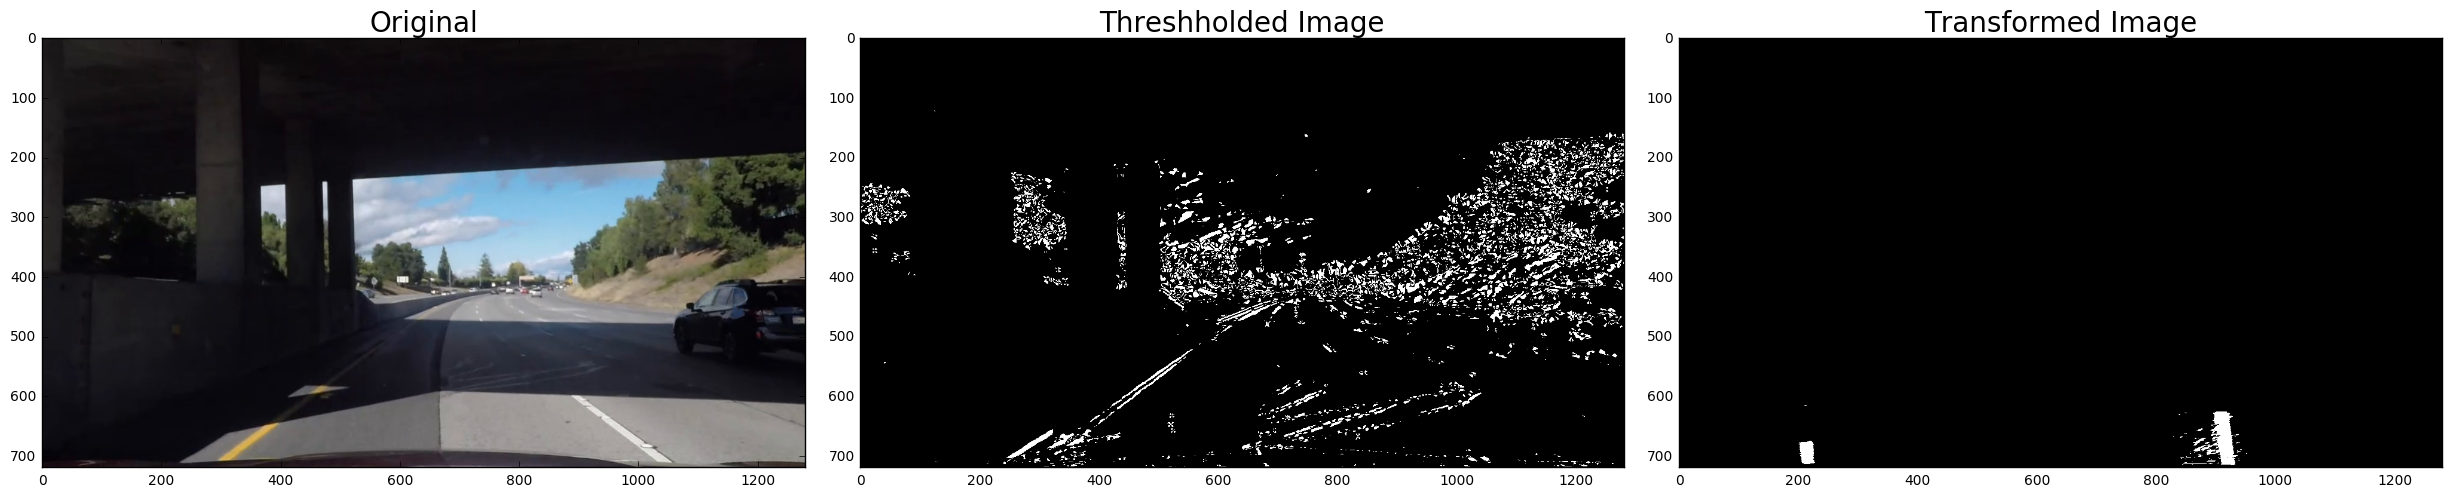

In [74]:
img = undist(clip.get_frame(4.3))
#combine(undist(img))
R = r_channel(img, thresh=(170, 255))
com_img = np.zeros_like(R)
com_img[(mag == 1) & (dirt == 1)] = 1

img_size = (img.shape[1], img.shape[0])
warped = cv2.warpPerspective(R, M, img_size, flags=cv2.INTER_LINEAR)
plot_images([ [img, com_img, warped] ], [ ['Original', 'Threshholded Image', 'Transformed Image'] ])

===>left min: 0 right min: 17
====>y_min: 17


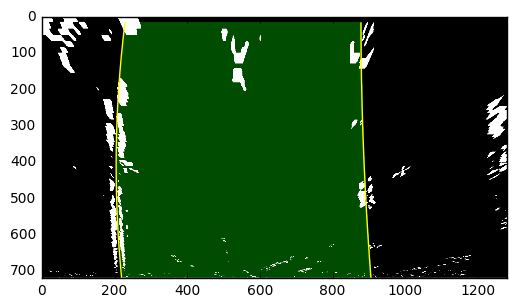

In [64]:
find, left_fitx, right_fitx, ploty, left_fit, right_fit = find_lane(warped)
if find:
    result = show_lane_line(left_fitx, right_fitx, ploty)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

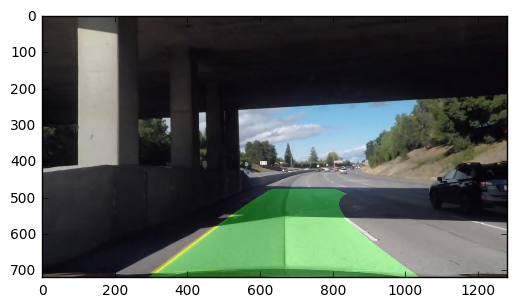

In [32]:
result = draw_lane(img = clip.get_frame(4.2))

plt.imshow(result)